# カメラデータの分類

## 【準備】基本的なライブラリのインポートとデータの読み込み

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/camera_dataset.csv')
df.head()

,Model,Release date,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price
0,Agfa ePhoto 1280,1997,1024.0,640.0,0.0,38.0,114.0,70.0,40.0,4.0,420.0,95.0,179.0
1,Agfa ePhoto 1680,1998,1280.0,640.0,1.0,38.0,114.0,50.0,0.0,4.0,420.0,158.0,179.0
2,Agfa ePhoto CL18,2000,640.0,0.0,0.0,45.0,45.0,0.0,0.0,2.0,0.0,0.0,179.0
3,Agfa ePhoto CL30,1999,1152.0,640.0,0.0,35.0,35.0,0.0,0.0,4.0,0.0,0.0,269.0
4,Agfa ePhoto CL30 Clik!,1999,1152.0,640.0,0.0,43.0,43.0,50.0,0.0,40.0,300.0,128.0,1299.0


### データのカラム
* Max resolution: 最大解像度
* Low resolution: 最低解像度
* Effective pixels: 有効画素数
* Zoom wide (W): ワイド端
* Zoom tele (T): テレ端
* Normal focus range: 通常のフォーカス
* Macro focus range: マクロフォーカス
* Storage included: 内部容量
* Weight (inc. batteries): 重さ(バッテリーを含む)
* Dimensions: 大きさ
* Price: 値段

## 【前処理】データクリーニング
欠損データや不正データが存在するかをチェックし、存在すれば削除や補間を行う。  
ここでは、欠損値の確認のみを行い、欠損しているカラムに特定の値0を代入している。

In [94]:
print(df.isnull().any(axis=0))
df['Macro focus range'] = df['Macro focus range'].fillna(0)
df['Storage included'] = df['Storage included'].fillna(0)
df['Weight (inc. batteries)'] = df['Weight (inc. batteries)'].fillna(0)
df['Dimensions'] = df['Dimensions'].fillna(0)
print(df.isnull().any(axis=0))

Model                      False
Release date               False
Max resolution             False
Low resolution             False
Effective pixels           False
Zoom wide (W)              False
Zoom tele (T)              False
Normal focus range         False
Macro focus range           True
Storage included            True
Weight (inc. batteries)     True
Dimensions                  True
Price                      False
dtype: bool
Model                      False
Release date               False
Max resolution             False
Low resolution             False
Effective pixels           False
Zoom wide (W)              False
Zoom tele (T)              False
Normal focus range         False
Macro focus range          False
Storage included           False
Weight (inc. batteries)    False
Dimensions                 False
Price                      False
dtype: bool


## 【学習】モデルの学習
KMeansのパラメータの学習を行う。  
ここでは、クラスタ数を6個に設定して学習させる。

In [116]:
from sklearn.cluster import KMeans

num_cl = 6
# モデルインスタンスをコンストラクト
model = KMeans(n_clusters=num_cl,            # クラスターの個数
#             init='random',           # セントロイドの初期値をランダムに設定  default: 'k-means++'
            random_state=48)          # セントロイドの初期化に用いる乱数発生器の状態

# モデルパラメータを入力データにフィッティングさせる
# (モデルパラメータの学習)
train_df = df.drop('Model', axis=1).drop('Release date', axis=1)
model.fit(train_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=48, tol=0.0001, verbose=0)

## 【予測】学習結果を用いて予測
学習に用いたデータがどのクラスタに分類されたかを確認している。  
出力は、各クラスタに分類されたデータの個数。

In [117]:
y_km = model.predict(train_df)
print('cluster: freq')
for label in range(num_cl): 
    freq = len([idx for idx in range(len(y_km)) if y_km[idx] == label])
    print('%d: %d'%(label, freq))

cluster: freq
0: 50
1: 359
2: 252
3: 288
4: 15
5: 74


## 【検証1】予測結果が妥当かどうかを検証
各データがどのように分類されているかを可視化して、目視で確認する。  
ここでは、PCA(主成分分析)という方法を用いて、高次元データを2次元まで次元削減を行っている。  
PCAによって2次元まで次元削減されたデータを平面にプロット。

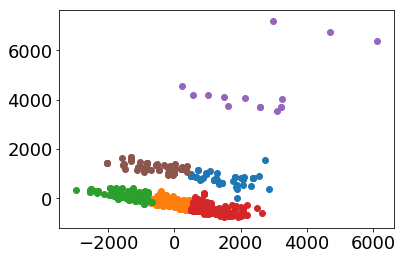

In [118]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(train_df)

x_kmeans = model.fit_transform(train_df)
labels_kmeans = [np.argmin(_) for _ in x_kmeans]

#################### 可視化 ####################
for label in np.arange(0, num_cl):
    plt.scatter(x_pca[labels_kmeans == label, 0], x_pca[labels_kmeans == label, 1])

## 【検証2】予測結果が妥当かどうかを検証

<Figure size 432x288 with 0 Axes>

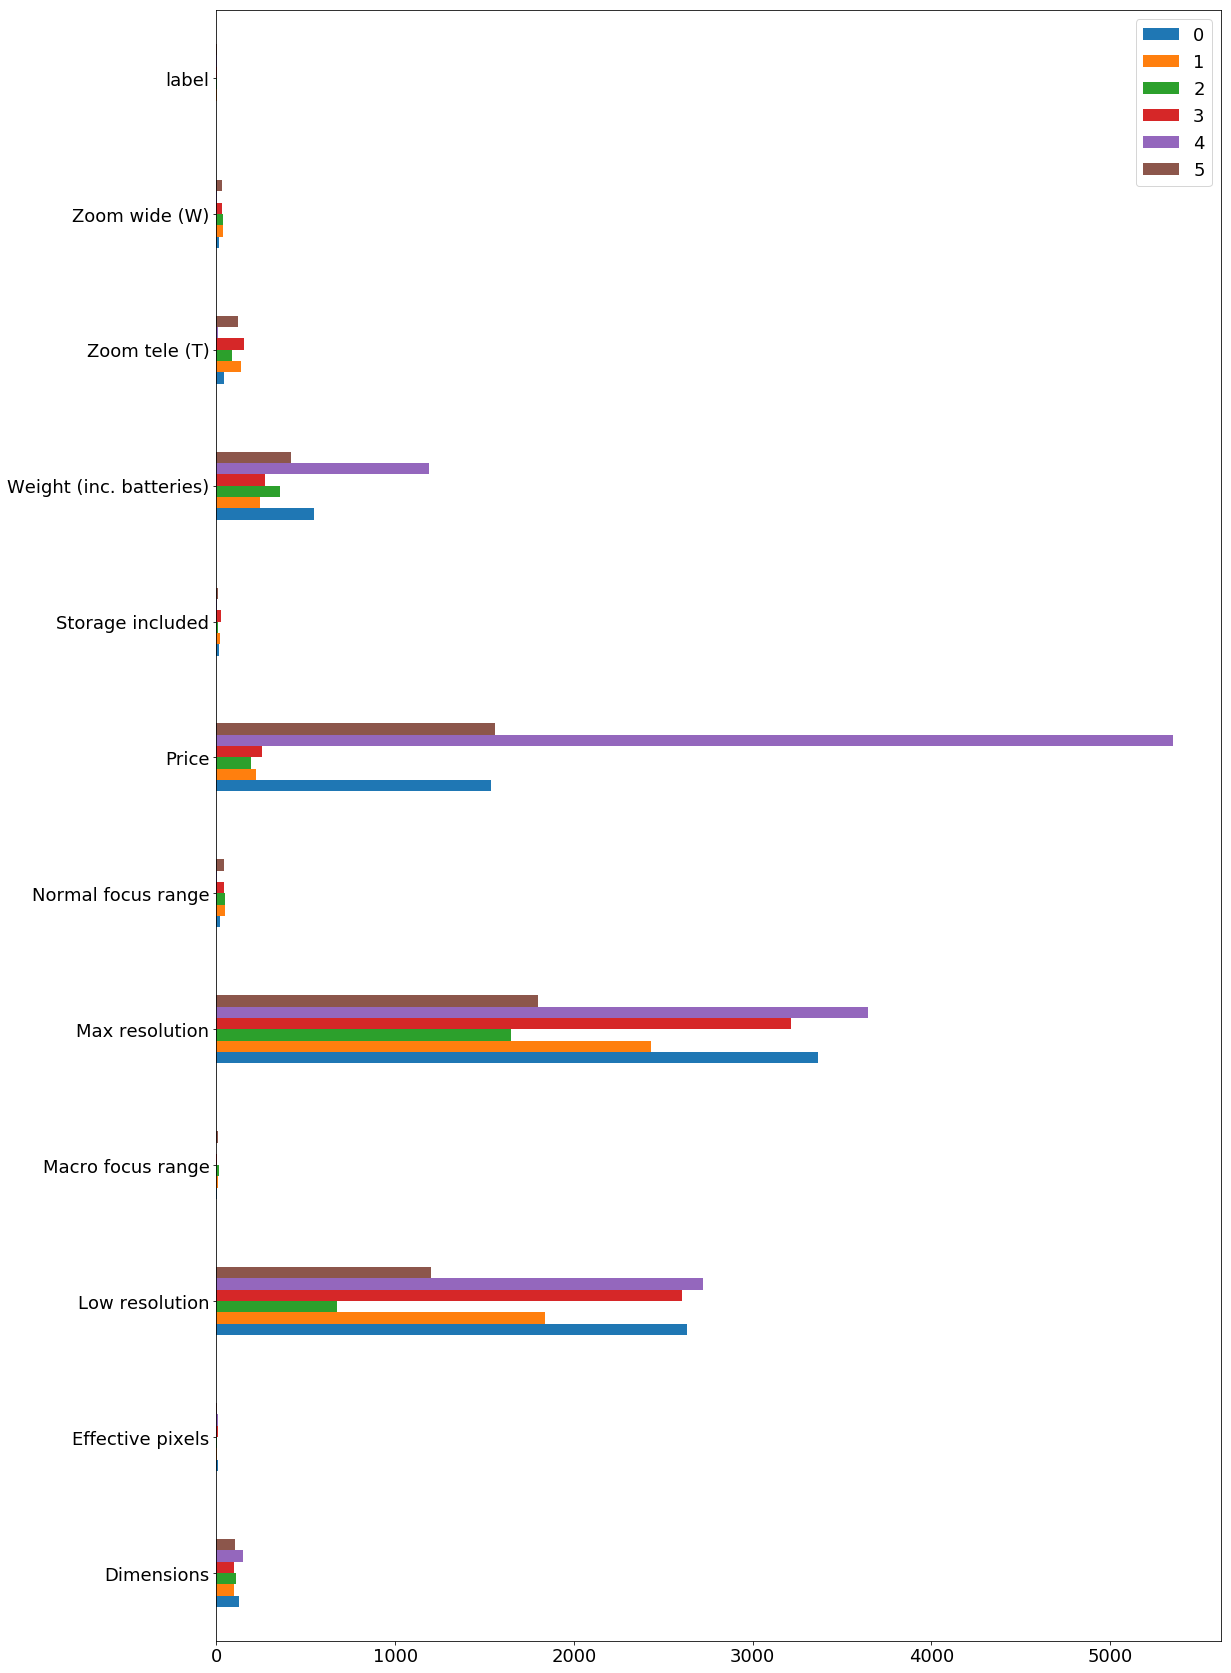

In [131]:
labels = pd.DataFrame(y_km, columns=['label'])
ret_df = pd.concat([train_df, labels], axis=1)

plt.figure()
plt.rcParams["font.size"] = 18

whole = pd.DataFrame()
for label in range(num_cl):
    tmp_df = ret_df[ret_df['label']==label]
    whole = pd.concat([whole, tmp_df.describe().loc['mean']], axis=1, sort=True)
whole.columns = ['%d'%idx for idx in range(num_cl)]
whole.plot(figsize=(18, 30), kind='barh')

In [132]:
ret_df[ret_df['label']==0].head()

,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price,label
47,3072.0,2048.0,6.0,0.0,0.0,0.0,0.0,0.0,875.0,150.0,1299.0,0
55,3504.0,2544.0,8.0,0.0,0.0,0.0,0.0,0.0,770.0,144.0,1299.0,0
56,3504.0,2544.0,8.0,0.0,0.0,0.0,0.0,0.0,770.0,144.0,1299.0,0
57,3072.0,2048.0,6.0,0.0,0.0,0.0,0.0,0.0,645.0,142.0,1299.0,0
58,3504.0,2544.0,8.0,0.0,0.0,0.0,0.0,0.0,784.0,144.0,1299.0,0


In [133]:
ret_df[ret_df['label']==1].head()

,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price,label
14,2048.0,1600.0,3.0,33.0,33.0,20.0,5.0,32.0,225.0,111.0,139.0,1
15,2048.0,1600.0,3.0,33.0,33.0,0.0,5.0,0.0,205.0,110.0,139.0,1
17,2048.0,1600.0,3.0,45.0,100.0,0.0,5.0,16.0,255.0,107.0,139.0,1
18,2048.0,1600.0,3.0,41.0,131.0,0.0,1.0,16.0,195.0,103.0,139.0,1
19,2272.0,1600.0,4.0,39.0,125.0,47.0,1.0,16.0,200.0,103.0,139.0,1


In [134]:
ret_df[ret_df['label']==2].head()

,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price,label
0,1024.0,640.0,0.0,38.0,114.0,70.0,40.0,4.0,420.0,95.0,179.0,2
1,1280.0,640.0,1.0,38.0,114.0,50.0,0.0,4.0,420.0,158.0,179.0,2
2,640.0,0.0,0.0,45.0,45.0,0.0,0.0,2.0,0.0,0.0,179.0,2
3,1152.0,640.0,0.0,35.0,35.0,0.0,0.0,4.0,0.0,0.0,269.0,2
5,1600.0,640.0,1.0,51.0,51.0,50.0,20.0,8.0,270.0,119.0,179.0,2


In [135]:
ret_df[ret_df['label']==3].head()

,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price,label
28,2816.0,2272.0,6.0,35.0,140.0,45.0,5.0,16.0,230.0,90.0,149.0,3
29,3072.0,2592.0,7.0,35.0,140.0,45.0,5.0,16.0,210.0,91.0,149.0,3
30,3072.0,2592.0,7.0,35.0,140.0,45.0,5.0,16.0,205.0,91.0,149.0,3
31,3072.0,2592.0,7.0,35.0,140.0,45.0,5.0,16.0,215.0,90.0,149.0,3
34,2592.0,2592.0,5.0,35.0,140.0,0.0,1.0,16.0,285.0,105.0,139.0,3


In [136]:
ret_df[ret_df['label']==4].head()

,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price,label
48,2464.0,1232.0,4.0,0.0,0.0,0.0,0.0,0.0,1585.0,156.0,4499.0,4
49,3504.0,3104.0,8.0,0.0,0.0,0.0,0.0,0.0,1565.0,156.0,4499.0,4
50,3888.0,3456.0,10.0,0.0,0.0,0.0,0.0,0.0,1335.0,156.0,4499.0,4
51,3504.0,3104.0,8.0,0.0,0.0,0.0,0.0,0.0,1565.0,156.0,4499.0,4
52,4064.0,2032.0,11.0,0.0,0.0,0.0,0.0,0.0,1585.0,156.0,7999.0,4


In [137]:
ret_df[ret_df['label']==5].head()

,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price,label
4,1152.0,640.0,0.0,43.0,43.0,50.0,0.0,40.0,300.0,128.0,1299.0,5
457,2048.0,1024.0,3.0,38.0,76.0,30.0,6.0,16.0,160.0,30.0,1699.0,5
458,2048.0,1600.0,3.0,35.0,105.0,55.0,12.0,16.0,205.0,92.0,1699.0,5
459,2048.0,1600.0,3.0,35.0,105.0,60.0,17.0,16.0,205.0,92.0,1699.0,5
460,2048.0,1024.0,3.0,35.0,105.0,55.0,12.0,16.0,175.0,32.0,1699.0,5
